# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 100, 100, 100, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 100, 100, 100, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.8073
Epoch 1/200, Iteration 2/12, Loss: 0.4986
Epoch 1/200, Iteration 3/12, Loss: 0.4038
Epoch 1/200, Iteration 4/12, Loss: 0.4934
Epoch 1/200, Iteration 5/12, Loss: 0.4826
Epoch 1/200, Iteration 6/12, Loss: 0.3124
Epoch 1/200, Iteration 7/12, Loss: 0.3498
Epoch 1/200, Iteration 8/12, Loss: 0.2987
Epoch 1/200, Iteration 9/12, Loss: 0.2795
Epoch 1/200, Iteration 10/12, Loss: 0.3148
Epoch 1/200, Iteration 11/12, Loss: 0.2652
Epoch 1/200, Iteration 12/12, Loss: 0.2862
Epoch 1/200, Iteration 13/12, Loss: 0.2120
Train Error: 
 Accuracy: 65.0%, Avg loss: 0.262131, MRE: 0.268632, MAE: 0.032665 

Test Error: 
 Accuracy: 73.0%, Avg loss: 0.233699, MRE: 0.194628, MAE: 0.029143 

Epoch 2/200, Iteration 1/12, Loss: 0.2439
Epoch 2/200, Iteration 2/12, Loss: 0.2146
Epoch 2/200, Iteration 3/12, Loss: 0.2355
Epoch 2/200, Iteration 4/12, Loss: 0.2670
Epoch 2/200, Iteration 5/12, Loss: 0.2080
Epoch 2/200, Iteration 6/12, Loss: 0.2262
Epoch 2/200, Iteration 7/12, Loss

Epoch 12/200, Iteration 12/12, Loss: 0.0904
Epoch 12/200, Iteration 13/12, Loss: 0.0588
Train Error: 
 Accuracy: 90.25%, Avg loss: 0.077932, MRE: 0.072753, MAE: 0.009364 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.073669, MRE: 0.057609, MAE: 0.008756 

Epoch 13/200, Iteration 1/12, Loss: 0.0830
Epoch 13/200, Iteration 2/12, Loss: 0.0654
Epoch 13/200, Iteration 3/12, Loss: 0.0922
Epoch 13/200, Iteration 4/12, Loss: 0.0807
Epoch 13/200, Iteration 5/12, Loss: 0.0754
Epoch 13/200, Iteration 6/12, Loss: 0.0653
Epoch 13/200, Iteration 7/12, Loss: 0.0759
Epoch 13/200, Iteration 8/12, Loss: 0.0713
Epoch 13/200, Iteration 9/12, Loss: 0.0727
Epoch 13/200, Iteration 10/12, Loss: 0.0704
Epoch 13/200, Iteration 11/12, Loss: 0.0794
Epoch 13/200, Iteration 12/12, Loss: 0.0838
Epoch 13/200, Iteration 13/12, Loss: 0.0632
Train Error: 
 Accuracy: 75.75%, Avg loss: 0.079740, MRE: 0.085517, MAE: 0.010043 

Test Error: 
 Accuracy: 82.0%, Avg loss: 0.071913, MRE: 0.065571, MAE: 0.009118 

Epoch 14/200, Ite

Train Error: 
 Accuracy: 96.88%, Avg loss: 0.054710, MRE: 0.045997, MAE: 0.007090 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.049500, MRE: 0.036663, MAE: 0.006382 

Epoch 25/200, Iteration 1/12, Loss: 0.0467
Epoch 25/200, Iteration 2/12, Loss: 0.1043
Epoch 25/200, Iteration 3/12, Loss: 0.1144
Epoch 25/200, Iteration 4/12, Loss: 0.0894
Epoch 25/200, Iteration 5/12, Loss: 0.1014
Epoch 25/200, Iteration 6/12, Loss: 0.0658
Epoch 25/200, Iteration 7/12, Loss: 0.0660
Epoch 25/200, Iteration 8/12, Loss: 0.0940
Epoch 25/200, Iteration 9/12, Loss: 0.0752
Epoch 25/200, Iteration 10/12, Loss: 0.0832
Epoch 25/200, Iteration 11/12, Loss: 0.0525
Epoch 25/200, Iteration 12/12, Loss: 0.0556
Epoch 25/200, Iteration 13/12, Loss: 0.0475
Train Error: 
 Accuracy: 86.38%, Avg loss: 0.055234, MRE: 0.039363, MAE: 0.007379 

Test Error: 
 Accuracy: 87.0%, Avg loss: 0.057547, MRE: 0.034443, MAE: 0.008084 

Epoch 26/200, Iteration 1/12, Loss: 0.0614
Epoch 26/200, Iteration 2/12, Loss: 0.0592
Epoch 26/200, Itera

Train Error: 
 Accuracy: 89.38%, Avg loss: 0.055376, MRE: 0.038769, MAE: 0.006861 

Test Error: 
 Accuracy: 87.0%, Avg loss: 0.054473, MRE: 0.031939, MAE: 0.006653 

Epoch 37/200, Iteration 1/12, Loss: 0.0592
Epoch 37/200, Iteration 2/12, Loss: 0.0571
Epoch 37/200, Iteration 3/12, Loss: 0.0648
Epoch 37/200, Iteration 4/12, Loss: 0.0436
Epoch 37/200, Iteration 5/12, Loss: 0.0568
Epoch 37/200, Iteration 6/12, Loss: 0.0554
Epoch 37/200, Iteration 7/12, Loss: 0.0649
Epoch 37/200, Iteration 8/12, Loss: 0.0462
Epoch 37/200, Iteration 9/12, Loss: 0.0534
Epoch 37/200, Iteration 10/12, Loss: 0.0504
Epoch 37/200, Iteration 11/12, Loss: 0.0624
Epoch 37/200, Iteration 12/12, Loss: 0.0684
Epoch 37/200, Iteration 13/12, Loss: 0.0797
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.038498, MRE: 0.029926, MAE: 0.005553 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.038728, MRE: 0.026211, MAE: 0.005628 

Epoch 38/200, Iteration 1/12, Loss: 0.0389
Epoch 38/200, Iteration 2/12, Loss: 0.0542
Epoch 38/200, Iterat

Epoch 48/200, Iteration 6/12, Loss: 0.0456
Epoch 48/200, Iteration 7/12, Loss: 0.0535
Epoch 48/200, Iteration 8/12, Loss: 0.0579
Epoch 48/200, Iteration 9/12, Loss: 0.0436
Epoch 48/200, Iteration 10/12, Loss: 0.0488
Epoch 48/200, Iteration 11/12, Loss: 0.0552
Epoch 48/200, Iteration 12/12, Loss: 0.0446
Epoch 48/200, Iteration 13/12, Loss: 0.0467
Train Error: 
 Accuracy: 94.12%, Avg loss: 0.062045, MRE: 0.045040, MAE: 0.008153 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.060554, MRE: 0.035141, MAE: 0.008221 

Epoch 49/200, Iteration 1/12, Loss: 0.0581
Epoch 49/200, Iteration 2/12, Loss: 0.0572
Epoch 49/200, Iteration 3/12, Loss: 0.0514
Epoch 49/200, Iteration 4/12, Loss: 0.0378
Epoch 49/200, Iteration 5/12, Loss: 0.0375
Epoch 49/200, Iteration 6/12, Loss: 0.0300
Epoch 49/200, Iteration 7/12, Loss: 0.0323
Epoch 49/200, Iteration 8/12, Loss: 0.0445
Epoch 49/200, Iteration 9/12, Loss: 0.0453
Epoch 49/200, Iteration 10/12, Loss: 0.0301
Epoch 49/200, Iteration 11/12, Loss: 0.0287
Epoch 49/20

Epoch 60/200, Iteration 8/12, Loss: 0.0140
Epoch 60/200, Iteration 9/12, Loss: 0.0152
Epoch 60/200, Iteration 10/12, Loss: 0.0106
Epoch 60/200, Iteration 11/12, Loss: 0.0129
Epoch 60/200, Iteration 12/12, Loss: 0.0103
Epoch 60/200, Iteration 13/12, Loss: 0.0134
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.013644, MRE: 0.013840, MAE: 0.001747 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.014278, MRE: 0.009954, MAE: 0.001821 

Epoch 61/200, Iteration 1/12, Loss: 0.0161
Epoch 61/200, Iteration 2/12, Loss: 0.0133
Epoch 61/200, Iteration 3/12, Loss: 0.0107
Epoch 61/200, Iteration 4/12, Loss: 0.0137
Epoch 61/200, Iteration 5/12, Loss: 0.0123
Epoch 61/200, Iteration 6/12, Loss: 0.0100
Epoch 61/200, Iteration 7/12, Loss: 0.0135
Epoch 61/200, Iteration 8/12, Loss: 0.0144
Epoch 61/200, Iteration 9/12, Loss: 0.0109
Epoch 61/200, Iteration 10/12, Loss: 0.0140
Epoch 61/200, Iteration 11/12, Loss: 0.0109
Epoch 61/200, Iteration 12/12, Loss: 0.0111
Epoch 61/200, Iteration 13/12, Loss: 0.0164
Train Erro

Epoch 72/200, Iteration 9/12, Loss: 0.0126
Epoch 72/200, Iteration 10/12, Loss: 0.0128
Epoch 72/200, Iteration 11/12, Loss: 0.0143
Epoch 72/200, Iteration 12/12, Loss: 0.0108
Epoch 72/200, Iteration 13/12, Loss: 0.0130
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.013000, MRE: 0.012531, MAE: 0.001547 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.012417, MRE: 0.008852, MAE: 0.001500 

Epoch 73/200, Iteration 1/12, Loss: 0.0141
Epoch 73/200, Iteration 2/12, Loss: 0.0106
Epoch 73/200, Iteration 3/12, Loss: 0.0125
Epoch 73/200, Iteration 4/12, Loss: 0.0122
Epoch 73/200, Iteration 5/12, Loss: 0.0083
Epoch 73/200, Iteration 6/12, Loss: 0.0123
Epoch 73/200, Iteration 7/12, Loss: 0.0084
Epoch 73/200, Iteration 8/12, Loss: 0.0119
Epoch 73/200, Iteration 9/12, Loss: 0.0098
Epoch 73/200, Iteration 10/12, Loss: 0.0081
Epoch 73/200, Iteration 11/12, Loss: 0.0124
Epoch 73/200, Iteration 12/12, Loss: 0.0137
Epoch 73/200, Iteration 13/12, Loss: 0.0096
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.011287, M

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.011581, MRE: 0.011773, MAE: 0.001559 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.011206, MRE: 0.008250, MAE: 0.001473 

Epoch 84/200, Iteration 1/12, Loss: 0.0151
Epoch 84/200, Iteration 2/12, Loss: 0.0124
Epoch 84/200, Iteration 3/12, Loss: 0.0103
Epoch 84/200, Iteration 4/12, Loss: 0.0140
Epoch 84/200, Iteration 5/12, Loss: 0.0088
Epoch 84/200, Iteration 6/12, Loss: 0.0081
Epoch 84/200, Iteration 7/12, Loss: 0.0128
Epoch 84/200, Iteration 8/12, Loss: 0.0124
Epoch 84/200, Iteration 9/12, Loss: 0.0096
Epoch 84/200, Iteration 10/12, Loss: 0.0109
Epoch 84/200, Iteration 11/12, Loss: 0.0112
Epoch 84/200, Iteration 12/12, Loss: 0.0099
Epoch 84/200, Iteration 13/12, Loss: 0.0087
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.011322, MRE: 0.011646, MAE: 0.001467 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.011978, MRE: 0.009024, MAE: 0.001528 

Epoch 85/200, Iteration 1/12, Loss: 0.0096
Epoch 85/200, Iteration 2/12, Loss: 0.0106
Epoch 85/200, Itera

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008200, MRE: 0.006179, MAE: 0.001063 

Epoch 96/200, Iteration 1/12, Loss: 0.0099
Epoch 96/200, Iteration 2/12, Loss: 0.0072
Epoch 96/200, Iteration 3/12, Loss: 0.0092
Epoch 96/200, Iteration 4/12, Loss: 0.0089
Epoch 96/200, Iteration 5/12, Loss: 0.0074
Epoch 96/200, Iteration 6/12, Loss: 0.0099
Epoch 96/200, Iteration 7/12, Loss: 0.0077
Epoch 96/200, Iteration 8/12, Loss: 0.0077
Epoch 96/200, Iteration 9/12, Loss: 0.0087
Epoch 96/200, Iteration 10/12, Loss: 0.0072
Epoch 96/200, Iteration 11/12, Loss: 0.0074
Epoch 96/200, Iteration 12/12, Loss: 0.0070
Epoch 96/200, Iteration 13/12, Loss: 0.0130
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.007995, MRE: 0.008159, MAE: 0.001044 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008560, MRE: 0.006339, MAE: 0.001113 

Epoch 97/200, Iteration 1/12, Loss: 0.0089
Epoch 97/200, Iteration 2/12, Loss: 0.0078
Epoch 97/200, Iteration 3/12, Loss: 0.0085
Epoch 97/200, Iteration 4/12, Loss: 0.0072
Epoch 97/200, Ite

Epoch 108/200, Iteration 6/12, Loss: 0.0067
Epoch 108/200, Iteration 7/12, Loss: 0.0059
Epoch 108/200, Iteration 8/12, Loss: 0.0077
Epoch 108/200, Iteration 9/12, Loss: 0.0067
Epoch 108/200, Iteration 10/12, Loss: 0.0072
Epoch 108/200, Iteration 11/12, Loss: 0.0061
Epoch 108/200, Iteration 12/12, Loss: 0.0055
Epoch 108/200, Iteration 13/12, Loss: 0.0048
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006747, MRE: 0.006913, MAE: 0.000881 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.007453, MRE: 0.005330, MAE: 0.000976 

Epoch 109/200, Iteration 1/12, Loss: 0.0062
Epoch 109/200, Iteration 2/12, Loss: 0.0055
Epoch 109/200, Iteration 3/12, Loss: 0.0066
Epoch 109/200, Iteration 4/12, Loss: 0.0083
Epoch 109/200, Iteration 5/12, Loss: 0.0064
Epoch 109/200, Iteration 6/12, Loss: 0.0068
Epoch 109/200, Iteration 7/12, Loss: 0.0049
Epoch 109/200, Iteration 8/12, Loss: 0.0060
Epoch 109/200, Iteration 9/12, Loss: 0.0057
Epoch 109/200, Iteration 10/12, Loss: 0.0082
Epoch 109/200, Iteration 11/12, Loss

Epoch 120/200, Iteration 13/12, Loss: 0.0039
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005108, MRE: 0.006048, MAE: 0.000680 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006009, MRE: 0.004658, MAE: 0.000786 

Epoch 121/200, Iteration 1/12, Loss: 0.0067
Epoch 121/200, Iteration 2/12, Loss: 0.0069
Epoch 121/200, Iteration 3/12, Loss: 0.0043
Epoch 121/200, Iteration 4/12, Loss: 0.0045
Epoch 121/200, Iteration 5/12, Loss: 0.0051
Epoch 121/200, Iteration 6/12, Loss: 0.0046
Epoch 121/200, Iteration 7/12, Loss: 0.0044
Epoch 121/200, Iteration 8/12, Loss: 0.0040
Epoch 121/200, Iteration 9/12, Loss: 0.0047
Epoch 121/200, Iteration 10/12, Loss: 0.0051
Epoch 121/200, Iteration 11/12, Loss: 0.0043
Epoch 121/200, Iteration 12/12, Loss: 0.0053
Epoch 121/200, Iteration 13/12, Loss: 0.0099
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005218, MRE: 0.006146, MAE: 0.000688 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005994, MRE: 0.004687, MAE: 0.000783 

Epoch 122/200, Iteration 1/12, Loss: 0.0042
Epo

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004927, MRE: 0.005817, MAE: 0.000652 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005966, MRE: 0.004619, MAE: 0.000781 

Epoch 133/200, Iteration 1/12, Loss: 0.0048
Epoch 133/200, Iteration 2/12, Loss: 0.0058
Epoch 133/200, Iteration 3/12, Loss: 0.0055
Epoch 133/200, Iteration 4/12, Loss: 0.0046
Epoch 133/200, Iteration 5/12, Loss: 0.0070
Epoch 133/200, Iteration 6/12, Loss: 0.0044
Epoch 133/200, Iteration 7/12, Loss: 0.0041
Epoch 133/200, Iteration 8/12, Loss: 0.0040
Epoch 133/200, Iteration 9/12, Loss: 0.0043
Epoch 133/200, Iteration 10/12, Loss: 0.0050
Epoch 133/200, Iteration 11/12, Loss: 0.0083
Epoch 133/200, Iteration 12/12, Loss: 0.0040
Epoch 133/200, Iteration 13/12, Loss: 0.0042
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005031, MRE: 0.005852, MAE: 0.000676 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005919, MRE: 0.004612, MAE: 0.000774 

Epoch 134/200, Iteration 1/12, Loss: 0.0047
Epoch 134/200, Iteration 2/12, Loss: 0.0038
Epoc

Epoch 144/200, Iteration 1/12, Loss: 0.0051
Epoch 144/200, Iteration 2/12, Loss: 0.0072
Epoch 144/200, Iteration 3/12, Loss: 0.0047
Epoch 144/200, Iteration 4/12, Loss: 0.0042
Epoch 144/200, Iteration 5/12, Loss: 0.0061
Epoch 144/200, Iteration 6/12, Loss: 0.0042
Epoch 144/200, Iteration 7/12, Loss: 0.0046
Epoch 144/200, Iteration 8/12, Loss: 0.0043
Epoch 144/200, Iteration 9/12, Loss: 0.0045
Epoch 144/200, Iteration 10/12, Loss: 0.0049
Epoch 144/200, Iteration 11/12, Loss: 0.0064
Epoch 144/200, Iteration 12/12, Loss: 0.0039
Epoch 144/200, Iteration 13/12, Loss: 0.0047
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004933, MRE: 0.005774, MAE: 0.000647 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005762, MRE: 0.004491, MAE: 0.000749 

Epoch 145/200, Iteration 1/12, Loss: 0.0049
Epoch 145/200, Iteration 2/12, Loss: 0.0062
Epoch 145/200, Iteration 3/12, Loss: 0.0067
Epoch 145/200, Iteration 4/12, Loss: 0.0055
Epoch 145/200, Iteration 5/12, Loss: 0.0040
Epoch 145/200, Iteration 6/12, Loss: 

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004761, MRE: 0.005571, MAE: 0.000639 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005560, MRE: 0.004421, MAE: 0.000728 

Epoch 156/200, Iteration 1/12, Loss: 0.0050
Epoch 156/200, Iteration 2/12, Loss: 0.0042
Epoch 156/200, Iteration 3/12, Loss: 0.0065
Epoch 156/200, Iteration 4/12, Loss: 0.0053
Epoch 156/200, Iteration 5/12, Loss: 0.0042
Epoch 156/200, Iteration 6/12, Loss: 0.0050
Epoch 156/200, Iteration 7/12, Loss: 0.0047
Epoch 156/200, Iteration 8/12, Loss: 0.0050
Epoch 156/200, Iteration 9/12, Loss: 0.0065
Epoch 156/200, Iteration 10/12, Loss: 0.0039
Epoch 156/200, Iteration 11/12, Loss: 0.0039
Epoch 156/200, Iteration 12/12, Loss: 0.0040
Epoch 156/200, Iteration 13/12, Loss: 0.0045
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004918, MRE: 0.007295, MAE: 0.000664 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005684, MRE: 0.004374, MAE: 0.000746 

Epoch 157/200, Iteration 1/12, Loss: 0.0043
Epoch 157/200, Iteration 2/12, Loss: 0.0044
Ep

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004444, MRE: 0.005253, MAE: 0.000592 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005486, MRE: 0.004280, MAE: 0.000717 

Epoch 168/200, Iteration 1/12, Loss: 0.0033
Epoch 168/200, Iteration 2/12, Loss: 0.0057
Epoch 168/200, Iteration 3/12, Loss: 0.0033
Epoch 168/200, Iteration 4/12, Loss: 0.0053
Epoch 168/200, Iteration 5/12, Loss: 0.0044
Epoch 168/200, Iteration 6/12, Loss: 0.0032
Epoch 168/200, Iteration 7/12, Loss: 0.0039
Epoch 168/200, Iteration 8/12, Loss: 0.0054
Epoch 168/200, Iteration 9/12, Loss: 0.0041
Epoch 168/200, Iteration 10/12, Loss: 0.0043
Epoch 168/200, Iteration 11/12, Loss: 0.0065
Epoch 168/200, Iteration 12/12, Loss: 0.0046
Epoch 168/200, Iteration 13/12, Loss: 0.0042
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004438, MRE: 0.005288, MAE: 0.000589 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005496, MRE: 0.004288, MAE: 0.000720 

Epoch 169/200, Iteration 1/12, Loss: 0.0036
Epoch 169/200, Iteration 2/12, Loss: 0.0064
Ep

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004482, MRE: 0.005308, MAE: 0.000592 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005475, MRE: 0.004277, MAE: 0.000715 

Epoch 180/200, Iteration 1/12, Loss: 0.0041
Epoch 180/200, Iteration 2/12, Loss: 0.0031
Epoch 180/200, Iteration 3/12, Loss: 0.0044
Epoch 180/200, Iteration 4/12, Loss: 0.0047
Epoch 180/200, Iteration 5/12, Loss: 0.0043
Epoch 180/200, Iteration 6/12, Loss: 0.0041
Epoch 180/200, Iteration 7/12, Loss: 0.0046
Epoch 180/200, Iteration 8/12, Loss: 0.0054
Epoch 180/200, Iteration 9/12, Loss: 0.0062
Epoch 180/200, Iteration 10/12, Loss: 0.0057
Epoch 180/200, Iteration 11/12, Loss: 0.0040
Epoch 180/200, Iteration 12/12, Loss: 0.0036
Epoch 180/200, Iteration 13/12, Loss: 0.0029
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004394, MRE: 0.005250, MAE: 0.000584 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005487, MRE: 0.004288, MAE: 0.000715 

Epoch 181/200, Iteration 1/12, Loss: 0.0056
Epoch 181/200, Iteration 2/12, Loss: 0.0044
Ep

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004481, MRE: 0.005300, MAE: 0.000594 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005476, MRE: 0.004281, MAE: 0.000714 

Epoch 192/200, Iteration 1/12, Loss: 0.0053
Epoch 192/200, Iteration 2/12, Loss: 0.0030
Epoch 192/200, Iteration 3/12, Loss: 0.0049
Epoch 192/200, Iteration 4/12, Loss: 0.0037
Epoch 192/200, Iteration 5/12, Loss: 0.0047
Epoch 192/200, Iteration 6/12, Loss: 0.0047
Epoch 192/200, Iteration 7/12, Loss: 0.0043
Epoch 192/200, Iteration 8/12, Loss: 0.0044
Epoch 192/200, Iteration 9/12, Loss: 0.0073
Epoch 192/200, Iteration 10/12, Loss: 0.0038
Epoch 192/200, Iteration 11/12, Loss: 0.0031
Epoch 192/200, Iteration 12/12, Loss: 0.0035
Epoch 192/200, Iteration 13/12, Loss: 0.0050
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004423, MRE: 0.005242, MAE: 0.000589 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005472, MRE: 0.004278, MAE: 0.000714 

Epoch 193/200, Iteration 1/12, Loss: 0.0035
Epoch 193/200, Iteration 2/12, Loss: 0.0038
Ep

#### Plots loss vs Epoch

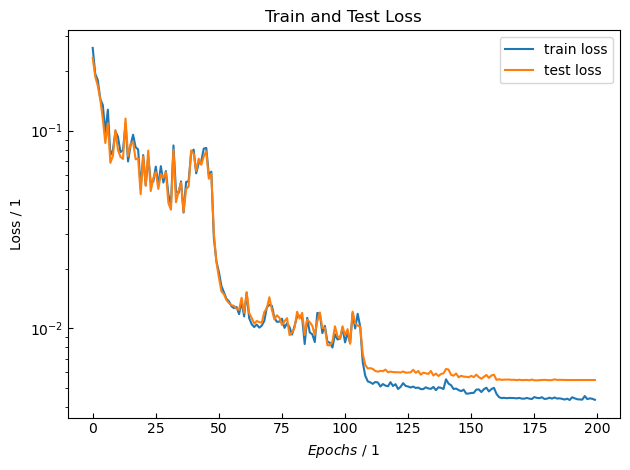

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9998583594067184 , R^2(NH3) = 0.9998833813770409
Test Dataset: R^2(H2) = 0.9999317036265609 , R^2(NH3) = 0.9998794380582335
Max Error Training: |x_H2 - x_H2,pred| = 0.04869065274605433 , |x_NH3 - x_NH3,pred| = 0.012232808451203891
Max Error Test: |x_H2 - x_H2,pred| = 0.008397455467939796 , |x_NH3 - x_NH3,pred| = 0.009689965673542258


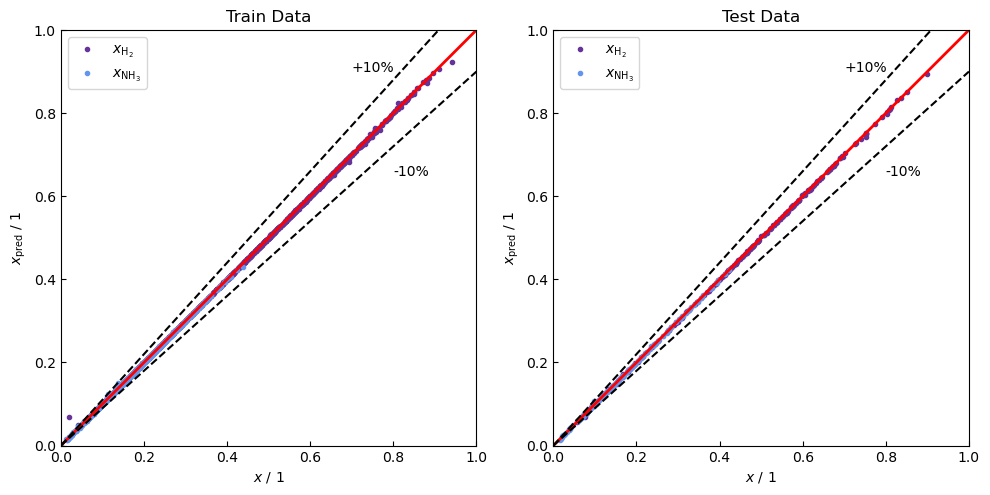

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

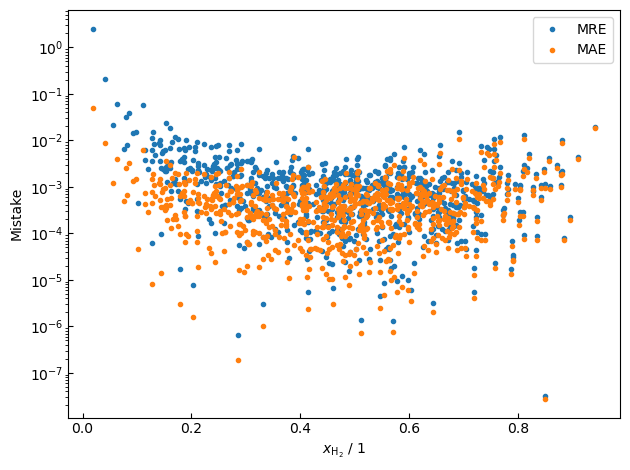

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

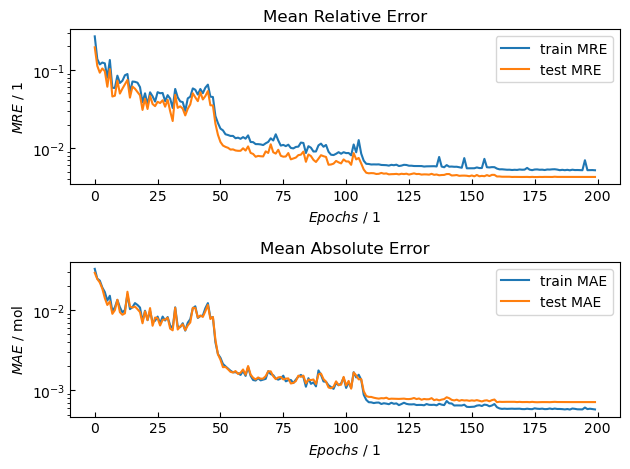

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

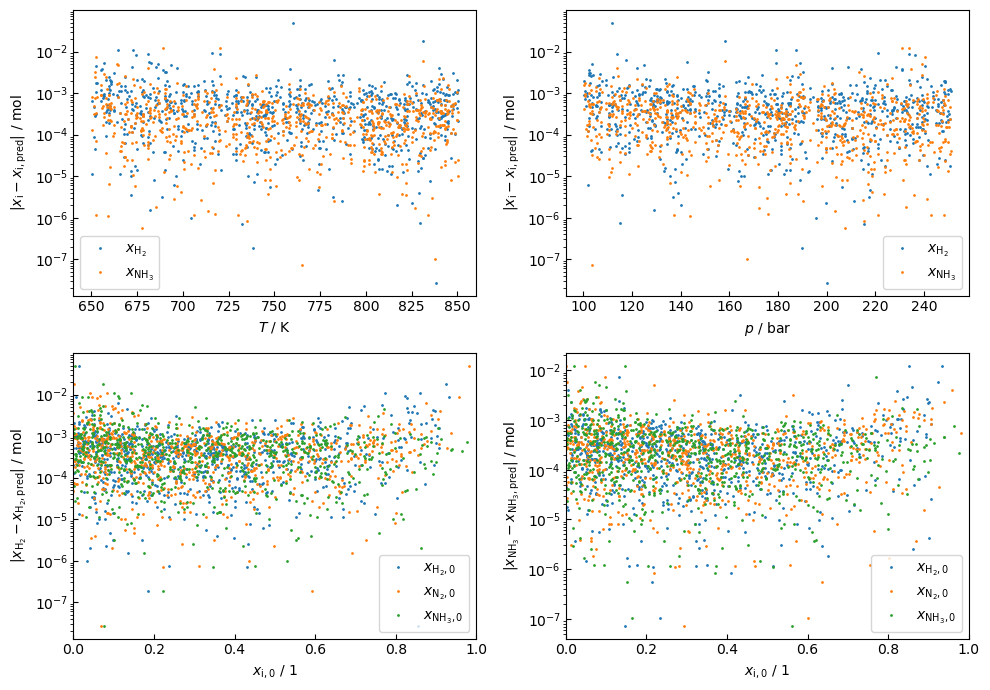

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

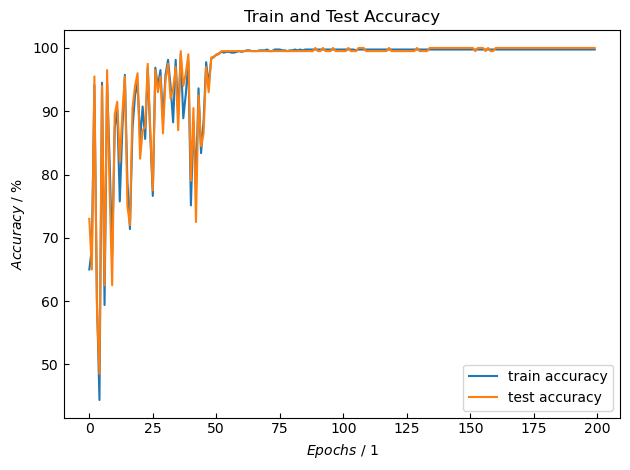

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 4.4469e-01, -1.3178e+00, -5.7149e-01,  5.5093e-01, -2.2314e-03],
        [ 9.9007e-01,  4.5866e-03,  1.3258e+00, -2.4641e-02, -1.2759e+00],
        [ 1.5129e+00, -1.0347e+00, -3.4243e-01,  6.6872e-02,  2.6770e-01],
        [ 1.4278e+00, -1.5541e+00, -2.7219e-02, -1.1204e+00,  1.1718e+00],
        [-9.8495e-01,  1.4651e+00,  5.7657e-01, -5.5475e-01,  1.1575e-03],
        [-3.4418e-01,  2.9310e-01, -5.0316e-01,  1.9839e-01,  2.9102e-01],
        [-1.0013e+00, -1.1647e+00, -7.8956e-01,  1.8161e+00, -1.0813e+00],
        [-1.0200e+00, -1.6840e+00,  5.8836e-01, -7.5977e-01,  1.9913e-01],
        [ 1.0139e+00, -4.1590e-01, -5.6929e-01,  1.8430e+00, -1.3250e+00],
        [ 1.1288e+00,  1.0831e+00, -2.9959e-01, -3.5383e-01,  6.5565e-01],
        [ 5.5718e-03,  8.5302e-01, -1.1338e+00,  6.8181e-01,  4.1580e-01],
        [-8.0487e-01, -1.4530e+00, -1.4150e+00, -2.8776e-01,  1.6828e+00],
        [-3.6225e-01,  1.6103e+00, -6.8104e-01, -5.9348e-01,  1.2749e+00],
        [ 7.4009e-01,  1.

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-0.1069, -0.0708,  0.1974,  0.3348,  0.2837],
         [-0.1185,  0.1919, -0.3051,  0.1016, -0.2972],
         [-0.3705,  0.0241,  0.0945,  0.4162, -0.0385],
         [ 0.0831,  0.0067, -0.0206, -0.0443, -0.1663],
         [ 0.3575, -0.0014,  0.3990, -0.2912,  0.2715],
         [-0.3211,  0.3030,  0.4201, -0.2545,  0.1951],
         [ 0.3150,  0.3850,  0.1463, -0.3392, -0.0036],
         [ 0.2606, -0.0923,  0.3017,  0.2087, -0.0246],
         [-0.2414, -0.2685, -0.0800, -0.1095,  0.1732],
         [ 0.1793, -0.0529,  0.3315,  0.4107,  0.3150],
         [ 0.1069, -0.0757,  0.0810,  0.3758,  0.1759],
         [-0.4165,  0.2340,  0.1594, -0.3182, -0.1812],
         [ 0.1894, -0.2464, -0.1666,  0.1798, -0.0712],
         [ 0.2708, -0.1079,  0.1596, -0.0723,  0.1902],
         [ 0.0564,  0.0577, -0.1463, -0.3750, -0.2935],
         [-0.1953, -0.0544,  0.2976, -0.0063,  0.2984],
         [-0.0744, -0.2066, -0.1957,  0.0414,  0.1146],
         [-0.0114,  0.006

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.4080, 0.8096, 0.5318, 0.2166, 0.7920],
        [0.7127, 0.3735, 0.8263, 0.2920, 0.6245]])
tensor([[ 0.2620, -0.0034],
        [ 0.4089, -0.3344]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 0.9667, -1.3365,  1.5060, -1.0696, -0.3848],
        [-1.6445,  1.6613, -1.3740,  0.8788,  0.4502],
        [ 0.5799, -1.4594, -0.7850,  1.8802, -1.1512],
        [-0.0592,  0.0667, -0.0464,  1.2511, -1.2332],
        [-1.0200, -1.6840,  0.5884, -0.7598,  0.1991],
        [-0.7383,  1.5948, -0.3181,  1.6572, -1.3816],
        [ 0.3444,  0.6332, -1.2000,  0.4484,  0.7194],
        [ 1.2151,  1.4542,  0.4052,  0.9685, -1.3875],
        [ 0.7534,  0.2113, -0.5100,  0.4256,  0.0655],
        [-0.2712, -1.2276, -0.1787, -0.9983,  1.1957],
        [ 1.3127, -0.6726,  0.1923, -0.2905,  0.1082],
        [-0.9028, -0.8521, -0.1506, -1.3107,  1.4875],
        [ 0.1989, -1.0380,  1.9884, -0.8658, -1.0665],
        [-0.1638,  1.3188, -0.0236,  0.2045, -0.1859],
        [-0.2900,  0.3243, -0.6408,  1.0681, -0.4628],
        [-1.5183, -0.0111,  1.4100, -0.0813, -1.3006],
        [ 1.0957, -0.2043, -1.0023, -0.1523,  1.1393],
        [ 0.6952, -1.3646, -1.1927,  1.9237, -0.7956],
        [-

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()